In [29]:
import pandas as pd
import seaborn as sns
df=pd.read_json('tsla.json')

In [30]:
df.head()

,date,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,ema_50,sma_100,ema_100,macd,bollinger,TrueRange,atr_7,atr_14,next_day_close
0,2014-01-02,9.986667,10.165333,9.770000,10.006667,92826000,55.344071,54.440118,-37.373644,15.213422,9.682107,9.820167,10.494240,9.674284,0.169472,9.740800,0.395333,0.402641,0.447550,9.970667
1,2014-01-03,10.000000,10.146000,9.906667,9.970667,70425000,53.742629,53.821521,-81.304471,17.481130,9.652800,9.826069,10.495693,9.680190,0.162623,9.776167,0.239333,0.379311,0.432677,9.800000
2,2014-01-06,10.000000,10.026667,9.682667,9.800000,80416500,46.328174,50.870410,-123.427544,-37.824708,9.629467,9.825047,10.496740,9.682577,0.141790,9.797900,0.344000,0.374267,0.426343,9.957333
3,2014-01-07,9.841333,10.026667,9.683333,9.957333,75511500,53.263037,53.406750,-84.784651,-20.779431,9.597747,9.830235,10.503407,9.688051,0.136402,9.837900,0.343334,0.369848,0.420414,10.085333
4,2014-01-08,9.923333,10.246667,9.917333,10.085333,92448000,58.368660,55.423026,60.799662,43.570559,9.573240,9.840239,10.511147,9.695964,0.140837,9.870167,0.329334,0.364060,0.413908,9.835333


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            2516 non-null   datetime64[ns]
 1   open            2516 non-null   float64       
 2   high            2516 non-null   float64       
 3   low             2516 non-null   float64       
 4   close           2516 non-null   float64       
 5   volume          2516 non-null   int64         
 6   rsi_7           2516 non-null   float64       
 7   rsi_14          2516 non-null   float64       
 8   cci_7           2516 non-null   float64       
 9   cci_14          2516 non-null   float64       
 10  sma_50          2516 non-null   float64       
 11  ema_50          2516 non-null   float64       
 12  sma_100         2516 non-null   float64       
 13  ema_100         2516 non-null   float64       
 14  macd            2516 non-null   float64       
 15  boll

In [32]:
def corr(df, col1, col2):
    print(f'{col1} vs {col2}:')
    corout=df[col1].corr(df[col2])
    print(f'Correlation with outliers: {corout}')
    q1=df[[col1, col2]].quantile(.25)
    q3=df[[col1, col2]].quantile(.75)
    IQR=q3-q1
    lb=q1-(1.5*IQR)
    hb=q3+(1.5*IQR)
    dfnoout=df.copy()
    idx=0
    for idx in range(len(dfnoout)):
        v1=dfnoout.loc[idx][col1]
        v2=dfnoout.loc[idx][col2]
        if v1>hb[col1] or v1<lb[col1]:
            dfnoout.drop([idx], inplace=True)
        if v2>hb[col2] or v1<lb[col2]:
            dfnoout.drop([idx], inplace=True)
    cornoout=dfnoout[col1].corr(dfnoout[col2])
    print(f'Correlation without outliers: {cornoout}')


In [25]:
corr(df, 'open', 'volume')

open vs volume:
Correlation with outliers: -0.048496276906608585
Correlation without outliers: 0.04557821259138341


In [33]:
def scatter(df, x, y, outliers):
    idx=[]
    for i in range(outliers):
        idx=df[x].idxmax()
        df.drop([idx], inplace=True)
    sns.scatterplot(data=df, x=x, y=y)

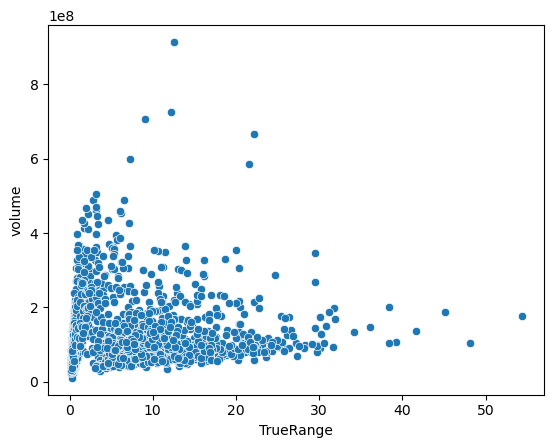

In [36]:
scatter(df, 'TrueRange', 'volume', 0)

In [37]:
def corrcalc(df, x, y, num_outliers):
    if num_outliers >0:
        for count in range(num_outliers):
            idx=df[df[x]==df[x].max()].index
            for i in idx:
                df.drop([i], inplace=True)
            idx=df[df[y]==df[y].max()].index
            for i in idx:
                df.drop([i], inplace=True)
    sub_df=df[[x,y]]
    return sub_df.corr(method='pearson')

In [38]:
corrcalc(df, 'TrueRange', 'volume', 0)

,TrueRange,volume
TrueRange,1.000000,0.145996
volume,0.145996,1.000000
